In [1]:
# import libraries

import os
import cv2
import time
import h5py
import math
import queue
import pickle
import random
import threading
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy
from keras.models import Model, load_model
from sklearn.utils import shuffle
from keras.regularizers import l2
from scipy import misc, ndimage
from keras.optimizers import *
from keras import backend as K
from keras.layers import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
# get name of available GPU devices. If you do not have any GPU, replace tensorflow-gpu with tensorflow to let
# the network use your CPU

tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# create csv file for the images and masks

if not os.path.exists('image.csv'):
    base_dir = os.path.join(os.getcwd(),'data')

    # generate csv file for images
    image_folder = base_dir + '\\images\\'
    images_in_folder = sorted(os.listdir(image_folder))

    # constructing data frame and saving csv file
    df = pd.DataFrame()
    df['images'] = [image_folder + str(x) for x in images_in_folder]
    df.to_csv('image.csv', header=None)

    # generate csv file for masks
    mask_folder = base_dir + '\\masks\\'
    masks_in_folder = sorted(os.listdir(mask_folder))

    # constructing data frame and saving csv file
    df = pd.DataFrame()
    df['masks'] = [mask_folder + str(x) for x in masks_in_folder]
    df.to_csv('mask.csv', header=None)

In [4]:
# import list of image and mask paths from the csv file
# NOTE: you can directly load image from the folder without any need for creating and loading from
#       a CSV file. However, its recommended to have a cvs file becasue it makes it easier to make
#       changes in the data set or loading only part of the dataset

import csv
def get_path_csv(folder, csv_file):
    with open(os.path.join(folder, csv_file), 'r') as f:
        reader = csv.reader(f)
        meta_data = list(reader)
        path_list = [item[1] for item in meta_data]
    return path_list
try:
    csvFile.close()
except:
    print("Could not close CSV file")
    
folder = os.getcwd()
img_path = get_path_csv(folder, 'image.csv')
mask_path = get_path_csv(folder, 'mask.csv')

Could not close CSV file


In [5]:
# load images; im_height & im_width can be selected. Larger resolution provides better result but 
# makes the training slow
# images are normalized to have intensity values between 0 and 1
# In this example images are loaded as gray scale (shape=(x,y)). Their dimensions are expanded by adding value of 1 to the 
# 3rd dimension (shape=(x,y,1)).

im_height = 64
im_width = 64

imgs = []
for i in img_path:
    img_array = cv2.imread(i, 1)/255
    new_array = cv2.resize(img_array, (im_height, im_width))
    #new_array = np.expand_dims(new_array, axis=-1)
    imgs.append(new_array)
    
masks = []
for i in mask_path:
    mask_array = cv2.imread(i, 1)/255
    new_mask = cv2.resize(mask_array, (im_height, im_width))
    #new_mask = np.expand_dims(new_mask, axis=-1)
    masks.append(new_mask)
    
    
# convert to numpy array
imgs_np = np.array(imgs, dtype=np.float32)
masks_np = np.array(masks, dtype=np.float32)

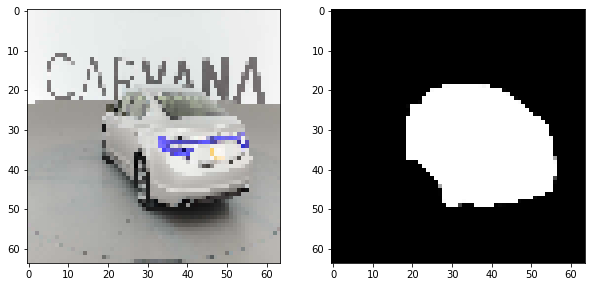

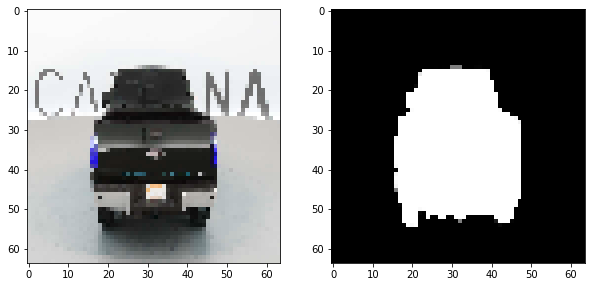

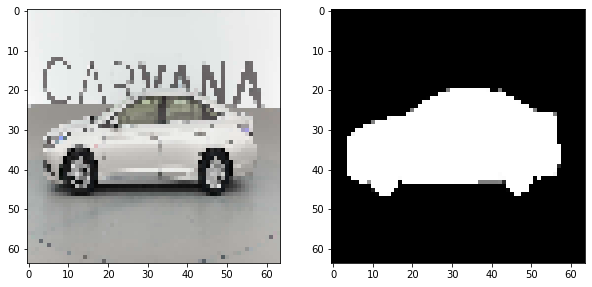

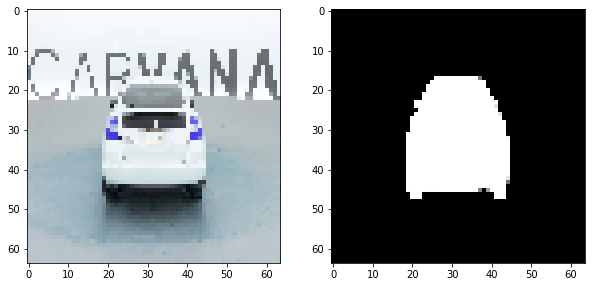

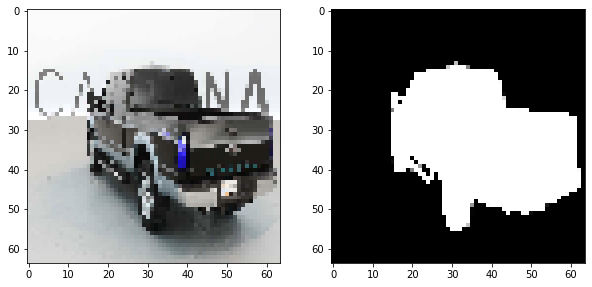

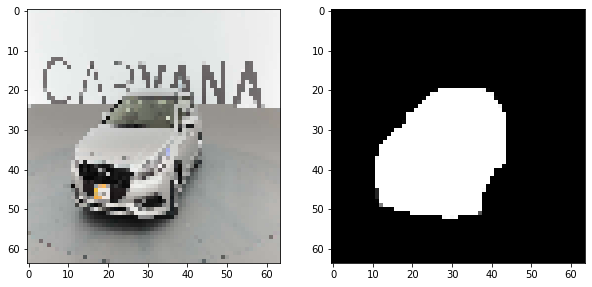

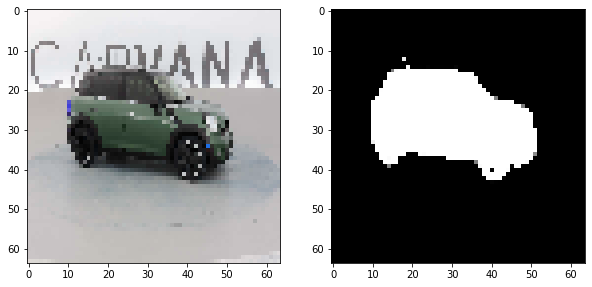

In [6]:
# show 7 randomly selected images and masks

rand_idx = random.choices(range(0,len(imgs)), k=7)

for i in rand_idx:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(imgs[i])
    ax[1].imshow(masks[i])

In [7]:
# split dataset for test and train

X_train, X_valid, y_train, y_valid = train_test_split(imgs_np, masks_np, test_size=0.2, random_state=1)

In [8]:
# define 2D convolutional layer with relu activation function

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [9]:
# define 2D Unet network

def get_unet(input_img, n_filters=2, dropout=0.5, batchnorm=True):
    
    # contracting path (encoder)
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path (decoder)
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
# select input size and model parameters. We used keras built-in binary crossentropy loss

input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=2, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 2)    56          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 2)    8           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 2)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [11]:
# define call back to save model and perform early stopping if loss does not imporove after 10 training epoch

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-car_segmentation.h5', verbose=1, save_best_only=True, save_weights_only=True)]

In [12]:
# train the model, select batch size and number of epoches

results = model.fit(X_train, y_train, batch_size=5, epochs=100, verbose=2, callbacks=None,
                    validation_data=(X_valid, y_valid))

Train on 115 samples, validate on 29 samples
Epoch 1/100
 - 7s - loss: 0.7478 - accuracy: 0.4982 - val_loss: 0.6900 - val_accuracy: 0.7709
Epoch 2/100
 - 1s - loss: 0.7087 - accuracy: 0.5357 - val_loss: 0.6855 - val_accuracy: 0.7743
Epoch 3/100
 - 1s - loss: 0.6789 - accuracy: 0.5514 - val_loss: 0.6966 - val_accuracy: 0.7841
Epoch 4/100
 - 1s - loss: 0.6530 - accuracy: 0.6267 - val_loss: 1.2258 - val_accuracy: 0.6141
Epoch 5/100
 - 1s - loss: 0.6332 - accuracy: 0.8405 - val_loss: 2.2489 - val_accuracy: 0.4663
Epoch 6/100
 - 1s - loss: 0.6177 - accuracy: 0.8892 - val_loss: 1.8265 - val_accuracy: 0.4965
Epoch 7/100
 - 1s - loss: 0.6037 - accuracy: 0.9013 - val_loss: 1.3763 - val_accuracy: 0.5756
Epoch 8/100
 - 1s - loss: 0.5900 - accuracy: 0.9101 - val_loss: 1.0355 - val_accuracy: 0.6452
Epoch 9/100
 - 1s - loss: 0.5745 - accuracy: 0.9233 - val_loss: 0.8780 - val_accuracy: 0.6813
Epoch 10/100
 - 1s - loss: 0.5584 - accuracy: 0.9342 - val_loss: 0.7516 - val_accuracy: 0.7187
Epoch 11/100
 

Epoch 87/100
 - 1s - loss: 0.1642 - accuracy: 0.9784 - val_loss: 0.1716 - val_accuracy: 0.9759
Epoch 88/100
 - 1s - loss: 0.1620 - accuracy: 0.9788 - val_loss: 0.1672 - val_accuracy: 0.9769
Epoch 89/100
 - 1s - loss: 0.1598 - accuracy: 0.9788 - val_loss: 0.1654 - val_accuracy: 0.9774
Epoch 90/100
 - 1s - loss: 0.1575 - accuracy: 0.9792 - val_loss: 0.1618 - val_accuracy: 0.9777
Epoch 91/100
 - 1s - loss: 0.1551 - accuracy: 0.9795 - val_loss: 0.1610 - val_accuracy: 0.9771
Epoch 92/100
 - 1s - loss: 0.1538 - accuracy: 0.9794 - val_loss: 0.1593 - val_accuracy: 0.9774
Epoch 93/100
 - 1s - loss: 0.1526 - accuracy: 0.9792 - val_loss: 0.1588 - val_accuracy: 0.9769
Epoch 94/100
 - 1s - loss: 0.1508 - accuracy: 0.9792 - val_loss: 0.1582 - val_accuracy: 0.9769
Epoch 95/100
 - 1s - loss: 0.1492 - accuracy: 0.9793 - val_loss: 0.1552 - val_accuracy: 0.9776
Epoch 96/100
 - 1s - loss: 0.1473 - accuracy: 0.9793 - val_loss: 0.1541 - val_accuracy: 0.9763
Epoch 97/100
 - 1s - loss: 0.1463 - accuracy: 0.97

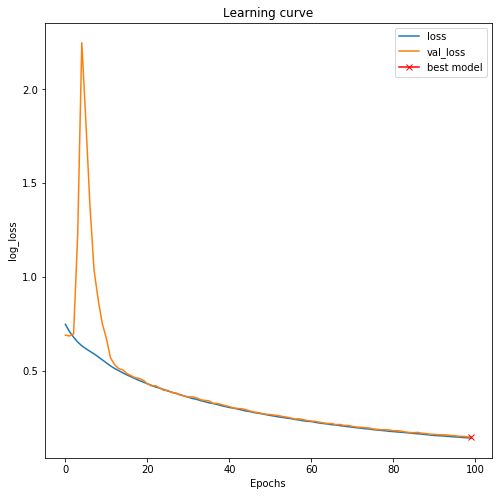

In [17]:
# plot training and validation loss, then highlight best model

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [18]:
# make prediction image based on the trained network

preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

29/29 [==============================] - 0s 516us/step


In [19]:
# model evaluation

loss, acc =  model.evaluate(X_valid, y_valid, batch_size=30, verbose=1)
display('Evaluation loss is equal to: {0:.2f}'.format(loss))
display('Evaluation accuracy is equal to: {0:.2f}'.format(acc))

29/29 [==============================] - 0s 602us/step


'Evaluation loss is equal to: 0.15'

'Evaluation accuracy is equal to: 0.98'

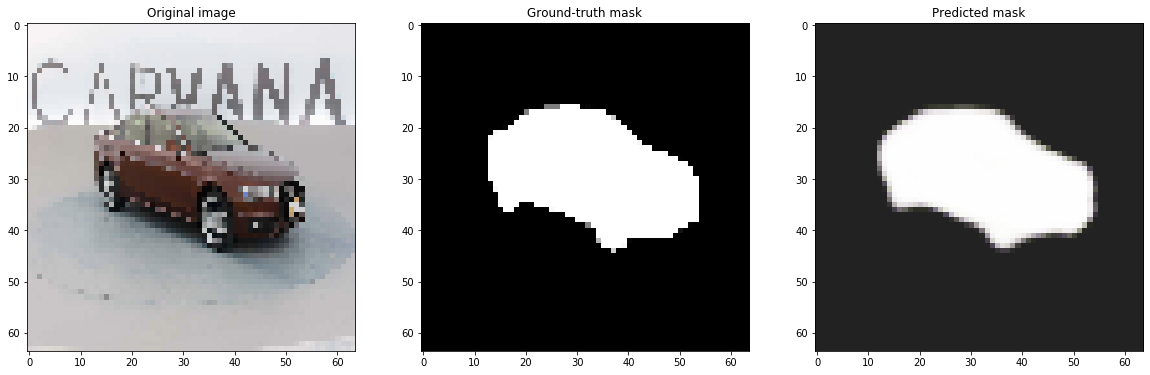

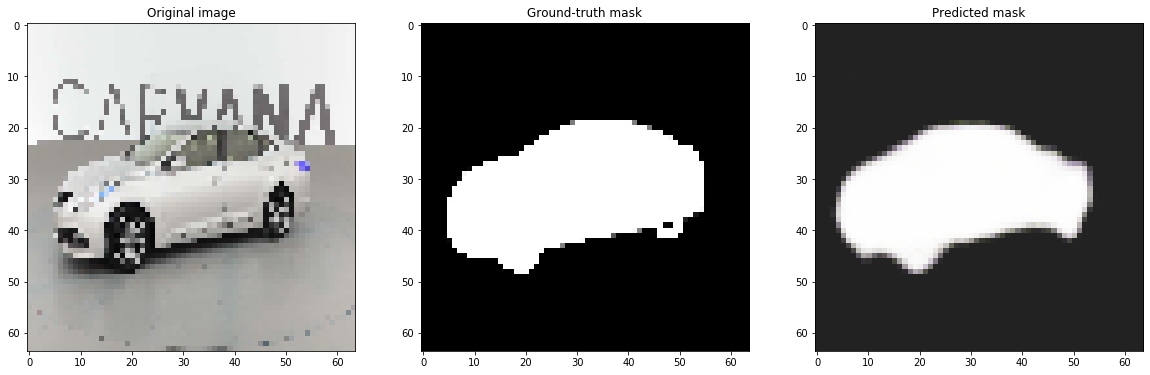

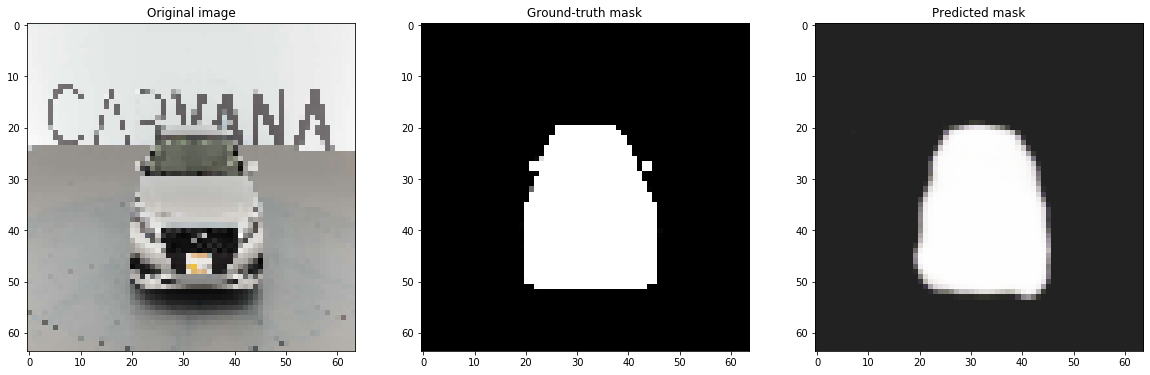

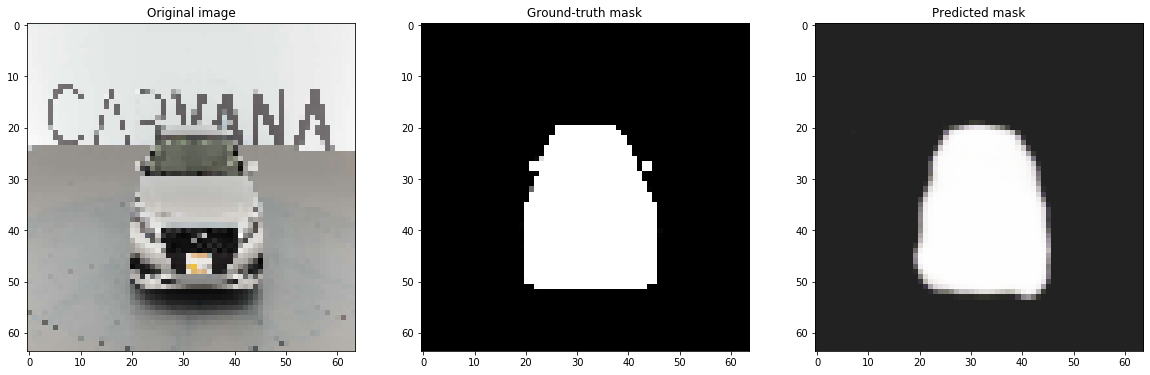

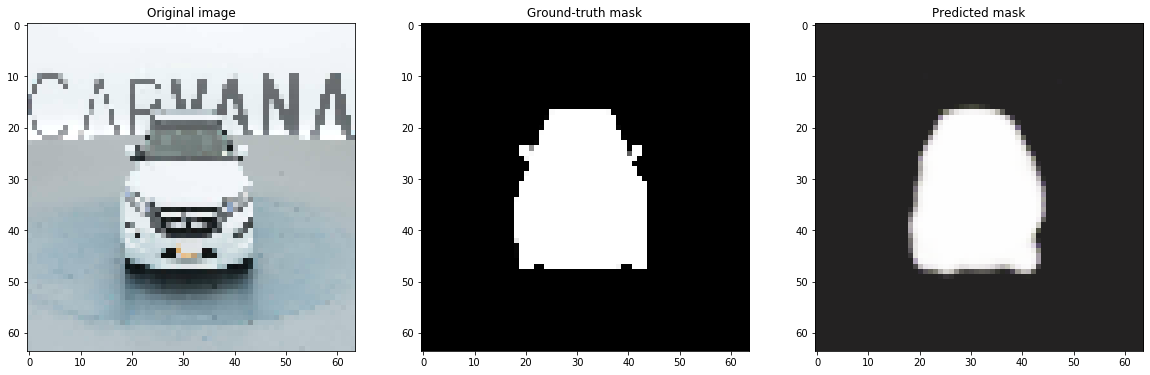

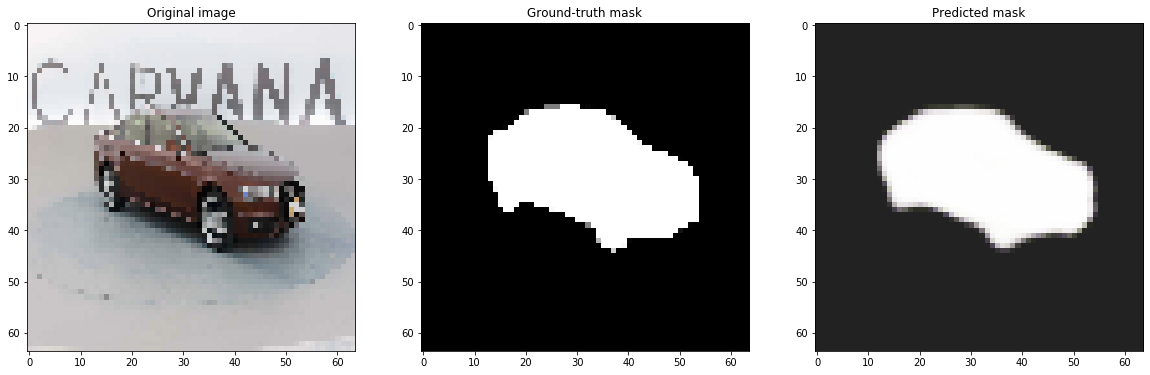

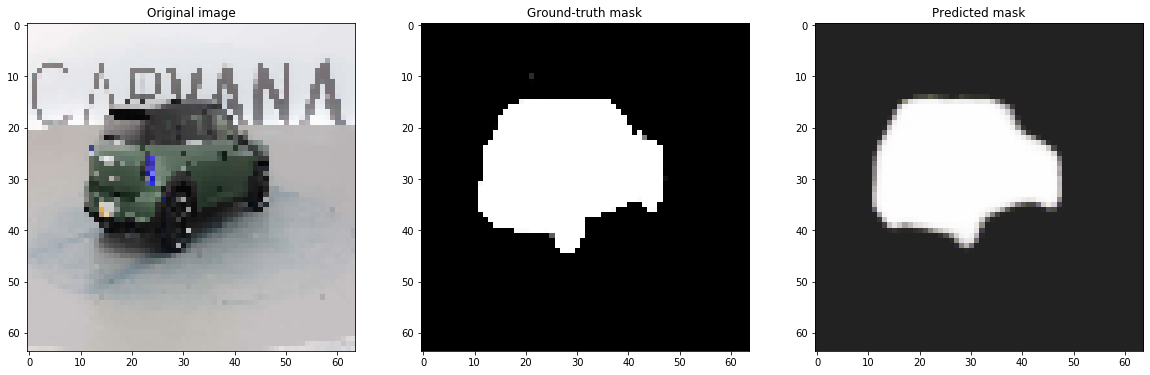

In [21]:
# show examples from validation dataset

rand_idx = random.choices(range(0,len(X_valid)), k=7)

for idx in rand_idx:
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X_valid[idx].squeeze(), cmap='gray')
    ax[0].title.set_text('Original image')
    ax[1].imshow(y_valid[idx].squeeze(), cmap='gray')
    ax[1].title.set_text('Ground-truth mask')
    ax[2].imshow(preds_val[idx].squeeze(), cmap='gray')
    ax[2].title.set_text('Predicted mask')